1. 边缘检测
1. 图像加法
2. 图像融合
3. 颜色空间
4. 阈值分割

## 边缘检测

<img src='images/边缘检测.jpg' width=50%>

图像边缘是由灰度突变产的，属于一种图像的特征，是目标探测、识别的重要手段之一。  
边缘检测保留了图片的所有细节信息，将图像进行二值化后，可以得到右图，其中去除了比较平稳光滑的部分。边缘检测的实质就是图像的卷积运算。  
所有的边缘检测算子都是基于灰度图像进行处理。

Canny算子和Sobel算子是常用的用于图像边缘检测的算子。  

In [ ]:
# canny边缘检测：1.灰度处理，2.高斯滤波(去除噪声)，3.调用canny方法

import cv2
import numpy as np
import random
img = cv2.imread('image0.jpg',1)
cv2.imshow('src',img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 使用高斯滤波器进行降噪，3x3内核
imgG = cv2.GaussianBlur(gray,(3,3),0)
# 使用Canny算法查找图像中的边缘
# 图片某处经过卷积后的值与阈值进行比较
dst = cv2.Canny(img,80,50)
cv2.imshow('dst',dst)
cv2.waitKey(0)

In [4]:
# sobel边缘检测步骤：
# 1 算子模版（有以下两种） 2 图片卷积 3 阈值判决 

# [ 1  2  1          [ 1  0  -1
#   0  0  0            2  0  -2
#  -1 -2 -1 ]          1  0  -1 ]
# 第一个算子是竖直方向上的算子，作用于y方向；第二个算子是水平方向上的算子，作用于x方向

# 图片的卷积是算子中的每个元素和图片中的像素对应相乘然后求和
# 比如：[[1 2] [3 4]]和[[a b] [c d]]  a*1+b*2+c*3+d*4 = dst

# 得到竖直方向和水平方向的两个梯度a和b，可以使用arctan计算梯度的总方向
# 使用sqrt(a*a+b*b)计算总的梯度值，如果该值大于阈值，就认为是边缘

In [5]:
# sobel边缘检测源码实现

import cv2
import numpy as np
import random

img = cv2.imread('image0.jpg',1)
imgInfo = img.shape
height = imgInfo[0]
width = imgInfo[1]

sobel_y = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])
sobel_x = np.array([[1,0,-1], [2,0,-2], [1,0,-1]])

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dst = np.zeros((height,width,1), np.uint8)
for i in range(0,height-2):# 因为算子是3*3，所以需要减2
    for j in range(0,width-2):
        gx = np.sum(sobel_x * gray[i:i+3,j:j+3])
        gy = np.sum(sobel_y * gray[i:i+3,j:j+3])
        grad = np.sqrt(gx**2+gy**2)
        # 阈值为50
        dst[i,j] = 255 if grad>50 else 0

cv2.imshow('src',img)
cv2.imshow('dst',dst)
cv2.waitKey(0)

-1

## 图像加法

使用cv2.add()将两幅图像进行加法运算，也可以直接使用numpy，res=img1+img2。两幅图像的大小，类型必须一致，或者第二个图像可以是一个简单的标量值。  
openCV的加法是一种饱和操作，而numpy的加法是一种模操作。OpenCV的结果会更好，所以尽量使用OpenCV中的函数。

In [9]:
x=np.uint8([250])
y=np.uint8([10])

print(cv2.add(x,y))# 250+10=260>=255

print (x+y)# 250+10=260%255=4

[[255]]
[4]


## 图片融合

融合效果是把两张图片的像素进行结合。这也是加法，不同的是两幅图像的权重不同，有种混合或者透明的感觉。

`dst  = src1*a + src2*(1-a)`，a来决定哪张图片占的比重大

<img src='images/图片融合.jpg' width=50%>

In [2]:
import cv2
import numpy as np
img0 = cv2.imread('image0.jpg',1)
img1 = cv2.imread('image1.jpg',1)
imgInfo = img0.shape
height = imgInfo[0]
width = imgInfo[1]

# ROI，两张图片尺寸保持一致
roiH = int(height/2)
roiW = int(width/2)
img0ROI = img0[0:roiH, 0:roiW]
img1ROI = img1[0:roiH, 0:roiW]
# dst
dst = np.zeros((roiH,roiW,3),np.uint8)
dst = cv2.addWeighted(img0ROI, 0.5, img1ROI, 0.5, 0) # src1*a + src2*(1-a)
# 1 src1 2 a 3 src2 4 1-a

# 直接对原图进行修改
img0[0:roiH, 0:roiW] = 0.5*img0[0:roiH, 0:roiW] + 0.5*img1[0:roiH, 0:roiW]

cv2.imshow('dst',dst)
cv2.imshow('img0',img0)
cv2.waitKey(0)

-1

## 颜色空间

通过颜色空间转换来提取带有某个特定颜色的物体，在 HSV 颜色空间中要比在 BGR 空间中更容易表示一个特定颜色。  
提取一个蓝色的物体步骤：
- 从视频中获取每一帧图像
- 将图像换到 HSV 空间
- 设置 HSV 阀值到蓝色范围
- 获取蓝色物体（可以在蓝色物体周围画一个圈）

追踪物体轮廓，可以找物体中心，然后跟踪物体，可以在摄像头前比划手来实现画图等操作。

In [1]:
import cv2
import numpy as np

cap = cv2.VideoCapture(0)

while(1):
    #获取每一帧
    ret, frame = cap.read()
    #转换到HSV
    hsv = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
    #设定蓝色的阀值
    lower_blue = np.array([110,50,50])
    upper_blue = np.array([130,255,255])
    #根据阀值构建掩模
    mask = cv2.inRange(hsv,lower_blue,upper_blue)
    #对原图和掩模进行位运算
    res = cv2.bitwise_and(frame,frame,mask=mask)
    #显示图像
    cv2.imshow('frame',frame)
    cv2.imshow('mask',mask)
    cv2.imshow('res',res)
    k = cv2.waitKey(1)
    if k == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## 阈值分割

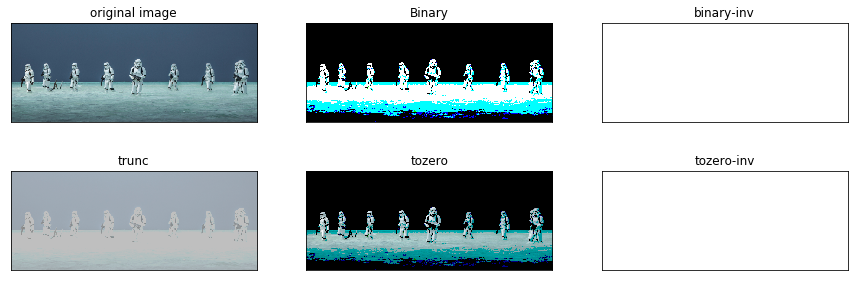

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = plt.imread('images/阈值分割.png',0)
ret , thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret , thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret , thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret , thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret , thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)

titles = ['original image','Binary','binary-inv','trunc','tozero','tozero-inv']
images = [img,thresh1,thresh2,thresh3,thresh4,thresh5]

plt.figure(figsize=(15,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()